## Step # 1 - Get the data

In [4]:
from importlib.resources import path
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
# housing = pd.read_csv(Path(r"D:\Other Topics\Notebooks& Source code\00-ML\handson-ml3-main\datasets\housing\housing.csv"))
housing = pd.read_csv(Path("handson-ml3-main/datasets/housing/housing.csv"))

In [5]:
# This function returns the first n rows for the object based on position. negative n, returns all rows except the last n rows default 5
# housing.head() 

housing.info()  # get a quick description of the data

# Return a Series containing counts of unique values. The resulting object will be in descending order
print('\n', housing["ocean_proximity"].value_counts(), '\n')

# Descriptive statistics include those that summarize the central tendency, dispersion and shape of a dataset's distribution
housing.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB

 <1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64 



,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [6]:
# extra code – code to save the figures as high-res PNGs for the book

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=720):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('text', color='c')
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('ytick', labelsize=10, labelcolor='white')
plt.rc('xtick', labelsize=10, labelcolor='white')

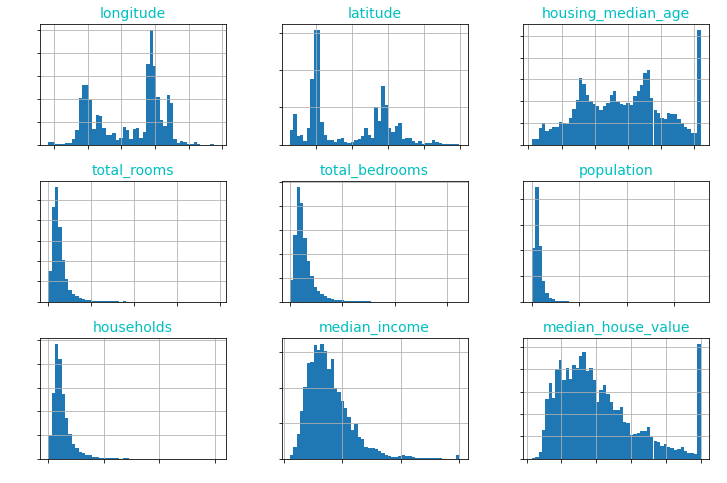

In [7]:
housing.hist(bins=50, figsize=(12, 8))
plt.show()

## 2 - Create a Test set 

When it comes to selecting rows and columns of a pandas DataFrame, ***loc and iloc*** are two commonly used functions. Here is the subtle difference between the two functions: **loc** selects rows and columns with specific labels. **iloc** selects rows and columns at specific integer positions.

In [8]:
def shuffle_and_split_data(data, test_ratio):
    shuffle_indices = np.random.permutation(len(data))
    test_size = int(test_ratio * len(shuffle_indices))
    test_indices = shuffle_indices[:test_size]
    train_indices = shuffle_indices[test_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = shuffle_and_split_data(housing, .2)
len(train_set)

16512

this works, but it is not perfect: if you run the program again, it will
generate a different test set! Over time, you (or your Machine Learning
algorithms) will get to see the whole dataset, which is what you want to
avoid dataset.   
  
To have a stable train/test split even after updating the dataset, a
common solution is to use each instance’s identifier to decide whether or
not it should go in the test set (assuming instances have a unique and
immutable identifier).  
  
If you use the row index as a unique identifier, you need to make sure that
new data gets appended to the end of the dataset and that no row ever gets
deleted. If this is not possible, then you can try to use the most stable
features to build a unique identifier.  
  
A ***cyclic redundancy check (CRC)*** is an error-detecting code commonly used in digital networks and storage devices to detect accidental changes to digital data. Blocks of data entering these systems get a short check value attached, based on the remainder of a polynomial division of their contents. On retrieval, the calculation is repeated and, in the event the check values do not match, corrective action can be taken against data corruption.  
  
`.apply` allow the users to pass a function and apply it on every single value of the Pandas series.

In [9]:
from zlib import crc32

def split_data_with_hash_id(data, test_ratio, id_column):
    ids = data[id_column]
    test_indices = ids.apply(lambda id_: crc32(np.int64(id_)) < test_ratio * 2**32)
    return data.loc[~test_indices], data.loc[test_indices]

housing_with_id = housing.reset_index()
housing_with_id["id"] = housing['latitude'] + housing['longitude'] * 1000
train_set, test_set = split_data_with_hash_id(housing_with_id, .2, "id")

Scikit-Learn provides a few functions to split datasets into multiple subsets
in various ways. The simplest function is train_test_split(), which
does pretty much the same thing as the function
shuffle_and_split_data() we defined earlier, with a couple of
additional features

In [10]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=.2, random_state=42)
test_set["total_bedrooms"].isnull().sum()

44

In [11]:
from scipy.stats import binom

# extra code – shows how to compute the 10.7% proba of getting a bad sample

# sample_size = 1000
# ratio_female = 0.511
# proba_too_small = binom(sample_size, ratio_female).cdf(485 - 1)
# proba_too_large = 1 - binom(sample_size, ratio_female).cdf(535)
# print(proba_too_small + proba_too_large)

print(binom(1000, .511).cdf(485 - 1) + (1 - binom(1000, .511).cdf(535)))

# extra code – shows another way to estimate the probability of bad sample

# np.random.seed(42)

# samples = (np.random.rand(100_000, sample_size) < ratio_female).sum(axis=1)
# ((samples < 485) | (samples > 535)).mean()

0.10736798530929913


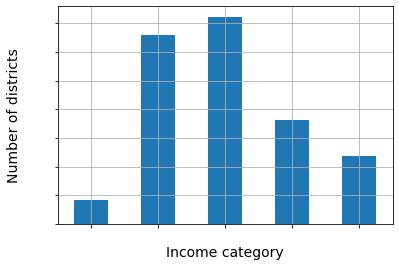

In [12]:
# stratified sampling

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

Scikit-Learn provides a number of splitter classes in the
`sklearn.model_selection` package, which implement various
strategies to split your dataset into a train set and a test set. Each splitter has
a `split()` method which returns an iterator over different train/test splits
of the same data. To be precise, the `split()` method yields the train and
test indices, not the data itself  
  
X : array-like of shape (n_samples, n_features)  
    Training data, where n_samples is the number of samples and n_features is the number of features.  

    Note that providing y is sufficient to generate the splits and hence np.zeros(n_samples) may be used as a placeholder for X instead of actual training data.  

y : array-like of shape (n_samples,) or (n_samples, n_labels)  
    The target variable for supervised learning problems. Stratification is done based on the y labels.  

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.loc[train_index]
    strat_test_set_n = housing.loc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

strat_train_set, strat_test_set = strat_splits[0]

In [14]:
# It's much shorter to get a single stratified split:

strat_train_set, strat_test_set = train_test_split(housing, test_size=.2, stratify=housing['income_cat'], random_state=42)

strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [15]:
# extra code – computes the data for Figure 2–10

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


In [16]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## 3 - Discover and visualize the data to gain insight

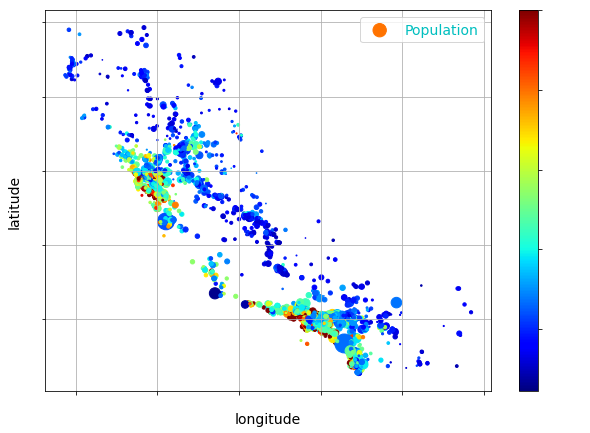

In [17]:
housing = strat_test_set.copy()

housing.plot(kind='scatter', x='longitude', y='latitude', grid=True, 
             s=housing['population'] / 100, label='Population', 
             c=housing['median_house_value'], cmap='jet', colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

median_house_value    1.000000
median_income         0.687091
total_rooms           0.121070
housing_median_age    0.118976
households            0.043549
total_bedrooms        0.029600
longitude            -0.026768
population           -0.040286
latitude             -0.162087
Name: median_house_value, dtype: float64


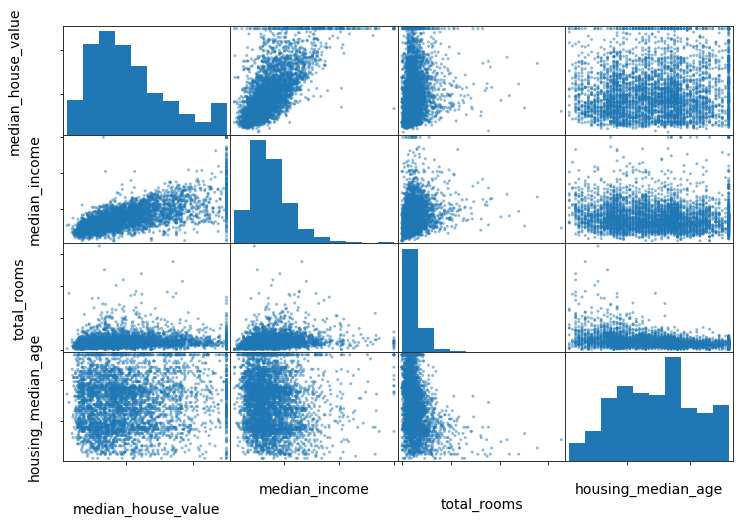

In [18]:
corr_matrix = housing.corr()
print(corr_matrix['median_house_value'].sort_values(ascending=False))

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
pd.plotting.scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

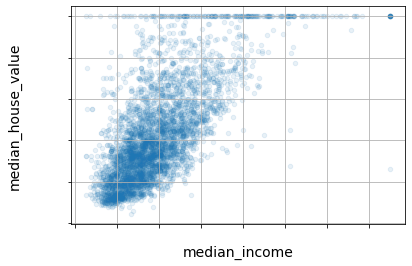

In [19]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
plt.show()

Experimenting with Attribute Combinations

In [20]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687091
rooms_per_house       0.198322
total_rooms           0.121070
housing_median_age    0.118976
households            0.043549
total_bedrooms        0.029600
people_per_house     -0.025974
longitude            -0.026768
population           -0.040286
latitude             -0.162087
bedrooms_ratio       -0.254506
Name: median_house_value, dtype: float64

## 4 - Prepare the data for Machine Learning

* Data Cleaning
* Handling Text and Categorical Data
* Feature Scaling and Transformation
* Custom Transformers
* Transformers Pipeline

(note that `strat_train_set.drop()` creates a copy of `strat_train_set` without the column, it doesn't actually modify `strat_train_set` itself, unless you pass `inplace=True`)

In [21]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

### Data Cleaning

`head()` displays the first five rows of the dataframe by default. It takes in a single parameter: the number of rows.  
`Inplace()` is an argument used in different functions. The default value of this attribute is False and it returns the copy of the object.

In [22]:
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


In [23]:
housing_option1 = housing.copy()
housing_option1.dropna(subset=["total_bedrooms"], inplace=True)  # option 1
print(housing_option1.loc[null_rows_idx].head())

housing_option2 = housing.copy()
housing_option2.drop("total_bedrooms", axis=1, inplace=True)  # option 2
display(housing_option2.loc[null_rows_idx].head())

housing_option3 = housing.copy()
median = housing["total_bedrooms"].median()
housing_option3["total_bedrooms"].fillna(median, inplace=True)  # option 3
housing_option3.loc[null_rows_idx].head()

Empty DataFrame
Columns: [longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, ocean_proximity]
Index: []


,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,375.0,183.0,9.8020,<1H OCEAN


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN


Separating out the numerical attributes to use the `"median"` strategy (as it cannot be calculated on text attributes like `ocean_proximity`):  
  
median of each attribute and stored the result in its `statistics_` instance variable  
all the `estimator’s learned parameters` are accessible via public instance variables with an underscore suffix - `imputer.statistics_`  
All the `estimator’s hyperparameters` are accessible directly via public instance variables - `imputer.strategy`  
  
Datasets are represented as NumPy arrays or SciPy sparse matrices, instead of homemade classes. Hyperparameters are just regular Python strings or numbers.  

In [24]:
from sklearn.impute import SimpleImputer

housing_num = housing.select_dtypes(include=[np.number])

imputer = SimpleImputer(strategy='median')

X = imputer.fit_transform(housing_num)

print(imputer.statistics_, '\n\n',                  
      imputer.strategy, '\n\n', 
      imputer.feature_names_in_, '\n\n')

housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)  ###  conv np.array into pd.DataFrame
housing_tr.loc[null_rows_idx].head()

[-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385] 

 median 

 ['longitude' 'latitude' 'housing_median_age' 'total_rooms'
 'total_bedrooms' 'population' 'households' 'median_income'] 




,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


### Handling Text and Categorical Data
`OrdinalEncoder` convert categories from text to numbers. One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases (e.g., for ordered categories such as “bad, “average,” “good,” and “excellent”), but it is obviously not the case for the ocean_proximity column.    
  
`OneHotEncoder` class to convert categorical values into one-hot vectors  
By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:  
Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:


In [25]:
from sklearn.preprocessing import OneHotEncoder

housing_cat = housing[["ocean_proximity"]]
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1h = cat_encoder.fit_transform(housing_cat)

print(housing_cat_1h, '\n')
print(cat_encoder.categories_, '\n\n', 
     cat_encoder.feature_names_in_)


[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]] 

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)] 

 ['ocean_proximity']


`OneHotEncoder` is smarter: it will detect the unknown category and
raise an exception. If you prefer, you can set the `handle_unknown`
hyperparameter to `"ignore"`, in which case it will just represent the
unknown category with zeros:

In [26]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})

cat_encoder.handle_unknown = "ignore"
print(cat_encoder.transform(df_test_unknown))

df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown), 
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)
display(df_output)

[[0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


In [27]:
# Now let's drop some outliers:

from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)

outlier_pred

array([-1,  1,  1, ...,  1,  1,  1])

### Feature Scaling

In [28]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

minmax_scaler = MinMaxScaler(feature_range=(-1, 1))
std_scalar = StandardScaler()

housing_minmax_scaled = minmax_scaler.fit_transform(housing_num)
housing_std_scaled = std_scalar.fit_transform(housing_num)



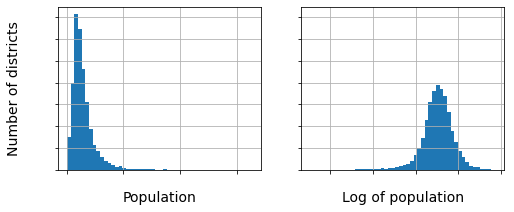

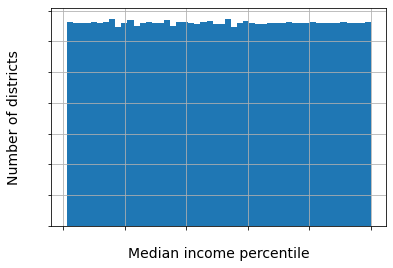

In [29]:
# extra code – this cell generates Figure 2–17
# P: Number of rows/columns of the subplot grid
# Controls sharing of properties among x (*sharex*) or y (*sharey*) axes:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
plt.show()


# What if we replace each value with its percentile?

# extra code – just shows that we get a uniform distribution
percentiles = [np.percentile(housing["median_income"], p)
               for p in range(1, 100)]
flattened_median_income = pd.cut(housing["median_income"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))
flattened_median_income.hist(bins=50)
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()
# Note: incomes below the 1st percentile are labeled 1, and incomes above the
# 99th percentile are labeled 100. This is why the distribution below ranges
# from 1 to 100 (not 0 to 100).

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(housing[['median_income']], housing_labels)
some_new_data = housing[["median_income"]].iloc[:5]  # pretend this is new data
predictions = model.predict(some_new_data)
print(predictions)


# Alternate Method Without TransformedTargetRegressor

# target_scaler = StandardScaler()
# scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

# model = LinearRegression()
# model.fit(housing[["median_income"]], scaled_labels)
# some_new_data = housing[["median_income"]].iloc[:5]  # pretend this is new data

# scaled_predictions = model.predict(some_new_data)
# predictions = target_scaler.inverse_transform(scaled_predictions)

[131997.15275877 299359.35844434 146023.37185694 138840.33653057
 192016.61557639]


### Custom Transformer  
  
`FunctionTransformer`  
Note: If a lambda is used as the function, then the resulting transformer will not be pickleable.  
  
**Pickling** is the process in which the objects in python are converted into simple binary representation that can be used to write that object in a text file which can be stored. This is done to store the python objects and is also called as **serialization**.  

In [31]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

log_trans = FunctionTransformer(np.log, inverse_func=np.exp)
rbf_trans = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35]], gamma=0.1))

log_pop = log_trans.transform(housing['population'])
age_simil_35 = rbf_trans.transform(housing[['housing_median_age']])

sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])


ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1, 2], [2, 4]]))

array([[0.5],
       [0.5]])

`BaseEstimator`: Base class for all estimators in scikit-learn. Notes. All estimators should specify all the parameters that can be set at the class level in their __init__ as explicit keyword arguments (no *args or **kwargs )  
  
You can get `fit_transform()` for free by simply adding `TransformerMixin` as a base class: the default implementation will just call `fit()` then `transform()`.  
If you add `BaseEstimator` as a base class (and avoid using *args and **kargs in your constructor), you will also get two extra methods: `get_params()` and `set_params()`. These will be useful for automatic hyperparameter tuning.
  
* `shape` returns a tuple denoting the dimensions of a  object on which it is applied.  
* The `assert keyword` is used when debugging code. it test if a condition in your code returns True, if not, the program will raise an AssertionError. You can write a message to be written if the code returns False  
  
All Scikit-Learn estimators set `n_features_in_` in the `fit()` method, and they ensure that the data passed to `transform()` or `predict()` has this number of features.


In [32]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StdScalarClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):         # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):                   # y is required even though we don't use it
        X = check_array(X)       # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.std_ = X.std(axis=0)
        self.feature_names_in_ = X.shape[1] # every estimator stores this in fit()
        return self     # always return self!

    def transform(self, X):
        check_is_fitted(X)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.feature_names_in_ == X.shape[1]   
        if self.with_mean:
            X = X - self.mean_
        return X / self.std_

In [33]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [34]:
def monkey_patch_get_signature_names_out():
    """Monkey patch some classes which did not handle get_feature_names_out()
       correctly in 1.0.0."""
    from inspect import Signature, signature, Parameter
    import pandas as pd
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import make_pipeline, Pipeline
    from sklearn.preprocessing import FunctionTransformer, StandardScaler

    default_get_feature_names_out = StandardScaler.get_feature_names_out

    if not hasattr(SimpleImputer, "get_feature_names_out"):
      print("Monkey-patching SimpleImputer.get_feature_names_out()")
      SimpleImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(FunctionTransformer, "get_feature_names_out"):
        print("Monkey-patching FunctionTransformer.get_feature_names_out()")
        orig_init = FunctionTransformer.__init__
        orig_sig = signature(orig_init)

        def __init__(*args, feature_names_out=None, **kwargs):
            orig_sig.bind(*args, **kwargs)
            orig_init(*args, **kwargs)
            args[0].feature_names_out = feature_names_out

        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values()) + [
                Parameter("feature_names_out", Parameter.KEYWORD_ONLY)])

        def get_feature_names_out(self, names=None):
            if self.feature_names_out is None:
                return default_get_feature_names_out(self, names)
            elif callable(self.feature_names_out):
                return self.feature_names_out(names)
            else:
                return self.feature_names_out

        FunctionTransformer.__init__ = __init__
        FunctionTransformer.get_feature_names_out = get_feature_names_out

monkey_patch_get_signature_names_out()

Monkey-patching SimpleImputer.get_feature_names_out()
Monkey-patching FunctionTransformer.get_feature_names_out()


### Transformation Pipeline

In [35]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config

set_config(display='diagram')


num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])
num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

display(num_pipeline)

housing_num_prepared = num_pipeline.fit_transform(housing_num)
display(housing_num_prepared[:2].round(2))

df_housing_num_prepared = pd.DataFrame(housing_num_prepared, columns=num_pipeline.get_feature_names_out(), index=housing_num.index)

display(num_pipeline[0])        # pipeline supports indexing
display(num_pipeline[1])

num_pipeline.named_steps["simpleimputer"]

num_pipeline.set_params(simpleimputer__strategy="median")

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

SimpleImputer(strategy='median')

StandardScaler()

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [36]:
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([                 # Transformers: list of tuples
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])


preprocessing = make_column_transformer(              # Transformers: tuples
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),)

display(preprocessing)

housing_prepared = preprocessing.fit_transform(housing)

housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index)
housing_prepared_fr.head(2)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f57277a7e50>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f57277a74f0>)])

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0


In [37]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_pipeline(name=None):
    return make_pipeline(SimpleImputer(strategy='median'),
                         FunctionTransformer(column_ratio, feature_names_out=[name]),
                         StandardScaler())

log_pipeline = make_pipeline(SimpleImputer(strategy='median'),
                             FunctionTransformer(np.log), 
                             StandardScaler())

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1, random_state=42)

default_num_pipeline = make_pipeline(SimpleImputer(strategy='median'),
                                     StandardScaler())

preprocessing = ColumnTransformer([
                ('bedrooms_ratio', ratio_pipeline('bedrooms_ratio'), ['total_bedrooms', 'total_rooms']),
                ("rooms_per_house", ratio_pipeline("rooms_per_house"),["total_rooms", "households"]),
                ("people_per_house", ratio_pipeline("people_per_house"),["population", "households"]),
                ('log', log_pipeline, ["total_bedrooms", "total_rooms","population", "households", "median_income"]),
                ("geo", cluster_simil, ["latitude", "longitude"]),
                ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
                ('def', default_num_pipeline, ['housing_median_age']),
            ])

preprocessing                    

ColumnTransformer(transformers=[('bedrooms_ratio',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out=['bedrooms_ratio'],
                                                                      func=<function column_ratio at 0x7f57277f1ee0>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['total_bedrooms', 'total_rooms']),
                                ('rooms_per_house',
                                 Pipeline(steps=[...
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f57245fba90>),
                                ('def',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['housing_median_age'])])

In [38]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

preprocessing.get_feature_names_out()   

array(['bedrooms_ratio__bedrooms_ratio',
       'rooms_per_house__rooms_per_house',
       'people_per_house__people_per_house', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'def__housing_median_age'], dtype=object)

## Step # 5 - Select and train a Model

### Training and Evaluating on the Training Set

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = make_pipeline(preprocessing, LinearRegression())
display(lin_reg.fit(housing, housing_labels))

housing_predictions = lin_reg.predict(housing)
print(housing_predictions[:5].round(-2)) # -2 = rounded to the nearest hundred
print('*' * 20)

print(housing_labels.iloc[:5].values)
print('*' * 20)

# extra code – computes the error ratios discussed in the book
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))
print('*' * 20)

lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
print(lin_rmse)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('bedrooms_ratio',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=['bedrooms_ratio'],
                                                                                       func=<function column_ratio at 0x7f57277f1ee0>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['total_bedrooms',
                                                   'total_rooms']...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f57245fba90>),
                                                 ('def',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['housing_median_age'])])),
                ('linearregression', LinearRegression())])

[243700. 372400. 128800.  94400. 328300.]
********************
[458300. 483800. 101700.  96100. 361800.]
********************
-46.8%, -23.0%, 26.6%, -1.8%, -9.3%
********************
68687.89176590125


`DecisionTreeRegressor`, as this is a fairly
powerful model capable of finding complex nonlinear relationships in the
data.  
  
`sklearn.tree` module includes decision tree-based models for classification and regression.  
**Decision Trees (DTs)** are a non-parametric supervised learning method used for classification and regression. 
The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. 
A tree can be seen as a piecewise constant approximation.  
  
A decision tree combines some decisions, whereas a `random forest` combines several decision trees. Thus, it is a long process, yet slow. Whereas, a decision tree is fast and operates easily on large data sets, especially the linear one. The random forest model needs rigorous training.

In [40]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
display(tree_reg.fit(housing, housing_labels))

housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
tree_rmse           # 0.0     NOTE Overfitting

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('bedrooms_ratio',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=['bedrooms_ratio'],
                                                                                       func=<function column_ratio at 0x7f57277f1ee0>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['total_bedrooms',
                                                   'total_rooms']...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f57245fba90>),
                                                 ('def',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['housing_median_age'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

0.0

### Better Evaluation Using Cross Validation

`K-fold cross-validation` feature.
The following code randomly splits the training set into 10 non-overlapping
subsets called folds, then it trains and evaluates the Decision Tree model 10
times, picking a different fold for evaluation every time and using the other
9 folds for training. The result is an array containing the 10 evaluation
scores:  
  
Scikit-Learn’s cross-validation features expect a `utility function` (greater is better) rather
than a `cost function` (lower is better), so the scoring function is actually the opposite of
the RMSE. It’s a negative value, which is why we need to switch the sign of the output
to get the RMSE scores.  

model_selection  
1. Cross-validation: evaluating estimator performance
2. Tuning the hyper-parameters of an estimator
3. Learning curve sections for further details.



In [41]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)

pd.Series(tree_rmses).describe()

count       10.000000
mean     66868.027288
std       2060.966425
min      63649.536493
25%      65338.078316
50%      66801.953094
75%      68229.934454
max      70094.778246
dtype: float64

In [42]:
# extra code – computes the error stats for the linear model
lin_rmses = -cross_val_score(lin_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count       10.000000
mean     69858.018195
std       4182.205077
min      65397.780144
25%      68070.536263
50%      68619.737842
75%      69810.076342
max      80959.348171
dtype: float64

`RandomForestRegressor`. Random Forests work by training many Decision
Trees on random subsets of the features, then averaging out their
predictions. Such models composed of many other models are called
`ensembles:` they are capable of boosting the performance of the underlying
model  
  
`ensemble module` includes two averaging algorithms based on randomized decision trees: the `RandomForest` algorithm and the `Extra-Trees` method. Both algorithms are perturb-and-combine techniques specifically designed for trees.  
improve the performance of machine learning models. For example to increase the accuracy of classification models or to reduce the mean absolute error for regression models.  

In [43]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)

In [44]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     47019.561281
std       1033.957120
min      45458.112527
25%      46464.031184
50%      46967.596354
75%      47325.694987
max      49243.765795
dtype: float64

In [45]:
forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
forest_rmse

17474.619286483998

The training error is much lower than the validation error, which usually means that the model has overfit the training set. Another possible explanation may be that there's a mismatch between the training data and the validation data, but it's not the case here, since both came from the same dataset that we shuffled and split in two parts.

## Step # 6 FIne Tune your Model

### Grid Search

In [46]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
        ('preprocessing', preprocessing),
        ('random_forest', RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
    'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
    'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('bedrooms_ratio',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=['bedrooms_ratio'],
                                                                                                              func=<function column_ratio at 0x7f57277f1ee0>)),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['total_...
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['housing_median_age'])])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

You can get the full list of hyperparameters available for tuning by looking at `full_pipeline.get_params().keys()`:

In [47]:
# extra code – shows part of the output of get_params().keys()
print(str(full_pipeline.get_params().keys())[:1000] + '...')

print('\n', grid_search.best_params_, '\n')

grid_search.best_estimator_

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'random_forest', 'preprocessing__n_jobs', 'preprocessing__remainder', 'preprocessing__sparse_threshold', 'preprocessing__transformer_weights', 'preprocessing__transformers', 'preprocessing__verbose', 'preprocessing__verbose_feature_names_out', 'preprocessing__bedrooms_ratio', 'preprocessing__rooms_per_house', 'preprocessing__people_per_house', 'preprocessing__log', 'preprocessing__geo', 'preprocessing__cat', 'preprocessing__def', 'preprocessing__bedrooms_ratio__memory', 'preprocessing__bedrooms_ratio__steps', 'preprocessing__bedrooms_ratio__verbose', 'preprocessing__bedrooms_ratio__simpleimputer', 'preprocessing__bedrooms_ratio__functiontransformer', 'preprocessing__bedrooms_ratio__standardscaler', 'preprocessing__bedrooms_ratio__simpleimputer__add_indicator', 'preprocessing__bedrooms_ratio__simpleimputer__copy', 'preprocessing__bedrooms_ratio__simpleimputer__fill_value', 'preprocessing__bedrooms_ratio__simpleimputer__missing_va

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('bedrooms_ratio',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=['bedrooms_ratio'],
                                                                                       func=<function column_ratio at 0x7f57277f1ee0>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['total_bedrooms',
                                                   'total_rooms']),
                                                 ('...
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f572471c160>),
                                                 ('def',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['housing_median_age'])])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

In [48]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by='mean_test_score', ascending=False, inplace=True)

# extra code – these few lines of code just make the DataFrame look nicer
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43460,43919,44748,44042
13,15,8,44132,44075,45010,44406
14,15,10,44374,44286,45316,44659
7,10,6,44683,44655,45657,44999
9,10,6,44683,44655,45657,44999


### Random Search

In [49]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                    'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(full_pipeline, param_distribs, n_iter=10, cv=3, scoring='neg_root_mean_squared_error', random_state=42)
rnd_search.fit(housing, housing_labels)


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('bedrooms_ratio',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out=['bedrooms_ratio'],
                                                                                                                    func=<function column_ratio at 0x7f57277f1ee0>)),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['...
                                                                               ['housing_median_age'])])),
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f57246d09a0>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5727a3f7c0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [50]:
# extra code – displays the random search results
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,41287,42150,42627,42021
8,32,7,41690,42542,43224,42485
0,41,16,42223,42959,43321,42834
5,42,4,41818,43094,43817,42910
2,23,8,42264,42996,43830,43030


**Bonus section: how to choose the sampling distribution for a hyperparameter**

* `scipy.stats.randint(a, b+1)`: for hyperparameters with _discrete_ values that range from a to b, and all values in that range seem equally likely.
* `scipy.stats.uniform(a, b)`: this is very similar, but for _continuous_ hyperparameters.
* `scipy.stats.geom(1 / scale)`: for discrete values, when you want to sample roughly in a given scale. E.g., with scale=1000 most samples will be in this ballpark, but ~10% of all samples will be <100 and ~10% will be >2300.
* `scipy.stats.expon(scale)`: this is the continuous equivalent of `geom`. Just set `scale` to the most likely value.
* `scipy.stats.reciprocal(a, b)`: when you have almost no idea what the optimal hyperparameter value's scale is. If you set a=0.01 and b=100, then you're just as likely to sample a value between 0.01 and 0.1 as a value between 10 and 100.


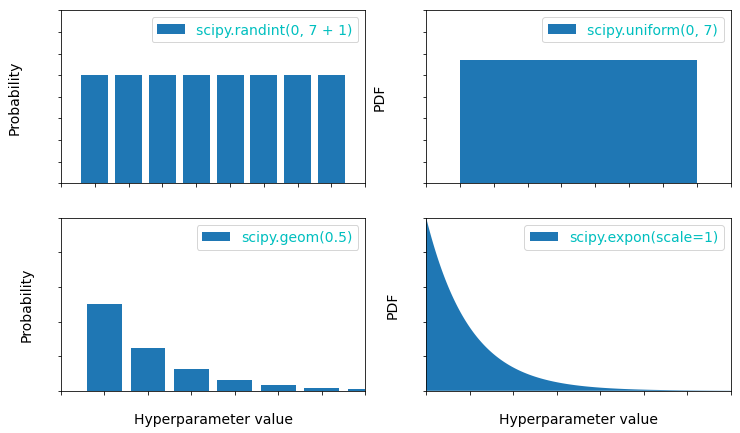

In [51]:
# extra code – plots a few distributions you can use in randomized search

from scipy.stats import randint, uniform, geom, expon

xs1 = np.arange(0, 7 + 1)
randint_distrib = randint(0, 7 + 1).pmf(xs1)

xs2 = np.linspace(0, 7, 500)
uniform_distrib = uniform(0, 7).pdf(xs2)

xs3 = np.arange(0, 7 + 1)
geom_distrib = geom(0.5).pmf(xs3)

xs4 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.bar(xs1, randint_distrib, label="scipy.randint(0, 7 + 1)")
plt.ylabel("Probability")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 2)
plt.fill_between(xs2, uniform_distrib, label="scipy.uniform(0, 7)")
plt.ylabel("PDF")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 3)
plt.bar(xs3, geom_distrib, label="scipy.geom(0.5)")
plt.xlabel("Hyperparameter value")
plt.ylabel("Probability")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 4)
plt.fill_between(xs4, expon_distrib, label="scipy.expon(scale=1)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.show()

Here are the PDF for `expon()` and `reciprocal()` (left column), as well as the PDF of log(X) (right column). The right column shows the distribution of hyperparameter _scales_. You can see that `expon()` favors hyperparameters with roughly the desired scale, with a longer tail towards the smaller scales. But `reciprocal()` does not favor any scale, they are all equally likely:

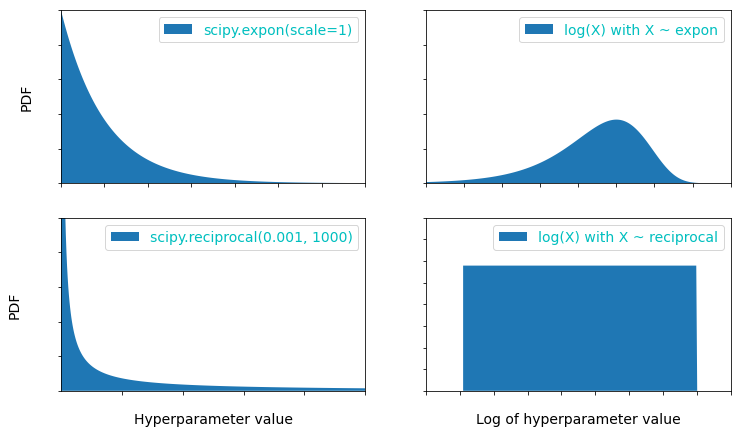

In [52]:
# extra code – shows the difference between expon and reciprocal

from scipy.stats import reciprocal

xs1 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs1)

log_xs2 = np.linspace(-5, 3, 500)
log_expon_distrib = np.exp(log_xs2 - np.exp(log_xs2))

xs3 = np.linspace(0.001, 1000, 500)
reciprocal_distrib = reciprocal(0.001, 1000).pdf(xs3)

log_xs4 = np.linspace(np.log(0.001), np.log(1000), 500)
log_reciprocal_distrib = uniform(np.log(0.001), np.log(1000)).pdf(log_xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.fill_between(xs1, expon_distrib,
                 label="scipy.expon(scale=1)")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 2)
plt.fill_between(log_xs2, log_expon_distrib,
                 label="log(X) with X ~ expon")
plt.legend()
plt.axis([-5, 3, 0, 1])

plt.subplot(2, 2, 3)
plt.fill_between(xs3, reciprocal_distrib,
                 label="scipy.reciprocal(0.001, 1000)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0.001, 1000, 0, 0.005])

plt.subplot(2, 2, 4)
plt.fill_between(log_xs4, log_reciprocal_distrib,
                 label="log(X) with X ~ reciprocal")
plt.xlabel("Log of hyperparameter value")
plt.legend()
plt.axis([-8, 1, 0, 0.2])

plt.show()

## Step # 7 Analyze the Best Models and Their Errors

In [53]:
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.07, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.04, 0.01, 0.  ,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01, 0.  , 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.02, 0.01, 0.01, 0.01, 0.02,
       0.01, 0.  , 0.02, 0.03, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01,
       0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.  , 0.07,
       0.  , 0.  , 0.  , 0.01])

In [54]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(0.18694559869103852, 'log__median_income'),
 (0.0748194905715524, 'cat__ocean_proximity_INLAND'),
 (0.06926417748515576, 'bedrooms_ratio__bedrooms_ratio'),
 (0.05446998753775219, 'rooms_per_house__rooms_per_house'),
 (0.05262301809680712, 'people_per_house__people_per_house'),
 (0.03819415873915732, 'geo__Cluster 0 similarity'),
 (0.02879263999929514, 'geo__Cluster 28 similarity'),
 (0.023530192521380392, 'geo__Cluster 24 similarity'),
 (0.020544786346378206, 'geo__Cluster 27 similarity'),
 (0.019873052631077512, 'geo__Cluster 43 similarity'),
 (0.018597511022930273, 'geo__Cluster 34 similarity'),
 (0.017409085415656868, 'geo__Cluster 37 similarity'),
 (0.015546519677632162, 'geo__Cluster 20 similarity'),
 (0.014230331127504292, 'geo__Cluster 17 similarity'),
 (0.0141032216204026, 'geo__Cluster 39 similarity'),
 (0.014065768027447325, 'geo__Cluster 9 similarity'),
 (0.01354220782825315, 'geo__Cluster 4 similarity'),
 (0.01348963625822907, 'geo__Cluster 3 similarity'),
 (0.01338319626

## Step # 8 Evaluate Your System on the Test Set

In [55]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

41424.40026462184


We can compute a 95% confidence interval for the test RMSE:

In [56]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
ci = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))
print(ci)


# extra code – shows how to compute a confidence interval for the RMSE
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
ci = np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)
print(ci)


# extra code – computes a confidence interval again using a z-score
# Alternatively, we could use a z-score rather than a t-score. Since the test set is not too small, it won't make a big difference:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

[39275.40861216 43467.27680583]
(39275.40861216077, 43467.27680583419)


(39276.05610140007, 43466.69174996963)

## Step # 10 Model persistence using joblib

In [57]:
import joblib

joblib.dump(final_model, "my_california_housing_model.pkl")

['my_california_housing_model.pkl']